# Data analysis on customer credit

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sqlalchemy import create_engine

# Import Data
df = pd.read_csv("/content/sample_data/CC GENERAL.csv")


# Explore Data
print("\nData Exploration:")
print("Here are the initial few rows of the dataset and its summary information to understand its structure.")
print(df.info())
print(df.describe())


# Identify missing values
print("\nMissing values:")
print("We identify missing values in the dataset.")
print(df.isna().sum())


median_credit_limit = df["CREDIT_LIMIT"].median()
df["CREDIT_LIMIT"].fillna(median_credit_limit,inplace = True)

median_min_payments = df["MINIMUM_PAYMENTS"].median()
df["MINIMUM_PAYMENTS"].fillna(median_min_payments,inplace = True)

# Removes any row with at least one NaN value
df= df.dropna()


# Verify changes
print("\nData after cleaning:")
print("We verify the changes by looking at the dataset summary again.")
print(df.info())
print(df.head())


Data Exploration:
Here are the initial few rows of the dataset and its summary information to understand its structure.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANC

/tmp/ipython-input-28-1930498501.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["CREDIT_LIMIT"].fillna(median_credit_limit,inplace = True)
/tmp/ipython-input-28-1930498501.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
# Calculate skewness of numerical columns
numerical_data = df.select_dtypes(include=np.number)

# Replace infinite values with NaN and drop rows with NaN values for skewness calculation
numerical_data = numerical_data.replace([np.inf, -np.inf], np.nan).dropna()

print("\nSkewness of numerical columns:")
print(numerical_data.skew())

import numpy as np

import numpy as np

# List of highly right-skewed columns (only positive values)
high_skew_cols = [
    'BALANCE',
    'PURCHASES',
    'ONEOFF_PURCHASES',
    'INSTALLMENTS_PURCHASES',
    'CASH_ADVANCE',
    'ONEOFF_PURCHASES_FREQUENCY',
    'CASH_ADVANCE_FREQUENCY',
    'CASH_ADVANCE_TRX',
    'PURCHASES_TRX',
    'CREDIT_LIMIT',
    'PAYMENTS',
    'MINIMUM_PAYMENTS',
    'PRC_FULL_PAYMENT'
]

# Overwrite columns with log1p (safe for zeros)
for col in high_skew_cols:
    df[col] = np.log1p(df[col])

print(df[high_skew_cols].skew())



Skewness of numerical columns:
BALANCE                              2.393386
BALANCE_FREQUENCY                   -2.023266
PURCHASES                            8.144269
ONEOFF_PURCHASES                    10.045083
INSTALLMENTS_PURCHASES               7.299120
CASH_ADVANCE                         5.166609
PURCHASES_FREQUENCY                  0.060164
ONEOFF_PURCHASES_FREQUENCY           1.535613
PURCHASES_INSTALLMENTS_FREQUENCY     0.509201
CASH_ADVANCE_FREQUENCY               1.828686
CASH_ADVANCE_TRX                     5.721298
PURCHASES_TRX                        4.630655
CREDIT_LIMIT                         1.522636
PAYMENTS                             5.907620
MINIMUM_PAYMENTS                    13.852446
PRC_FULL_PAYMENT                     1.942820
TENURE                              -2.943017
dtype: float64
BALANCE                      -0.861021
PURCHASES                    -0.764492
ONEOFF_PURCHASES              0.185854
INSTALLMENTS_PURCHASES       -0.024981
CASH_ADVANCE   


Spearman Correlation Matrix (first 5 rows):


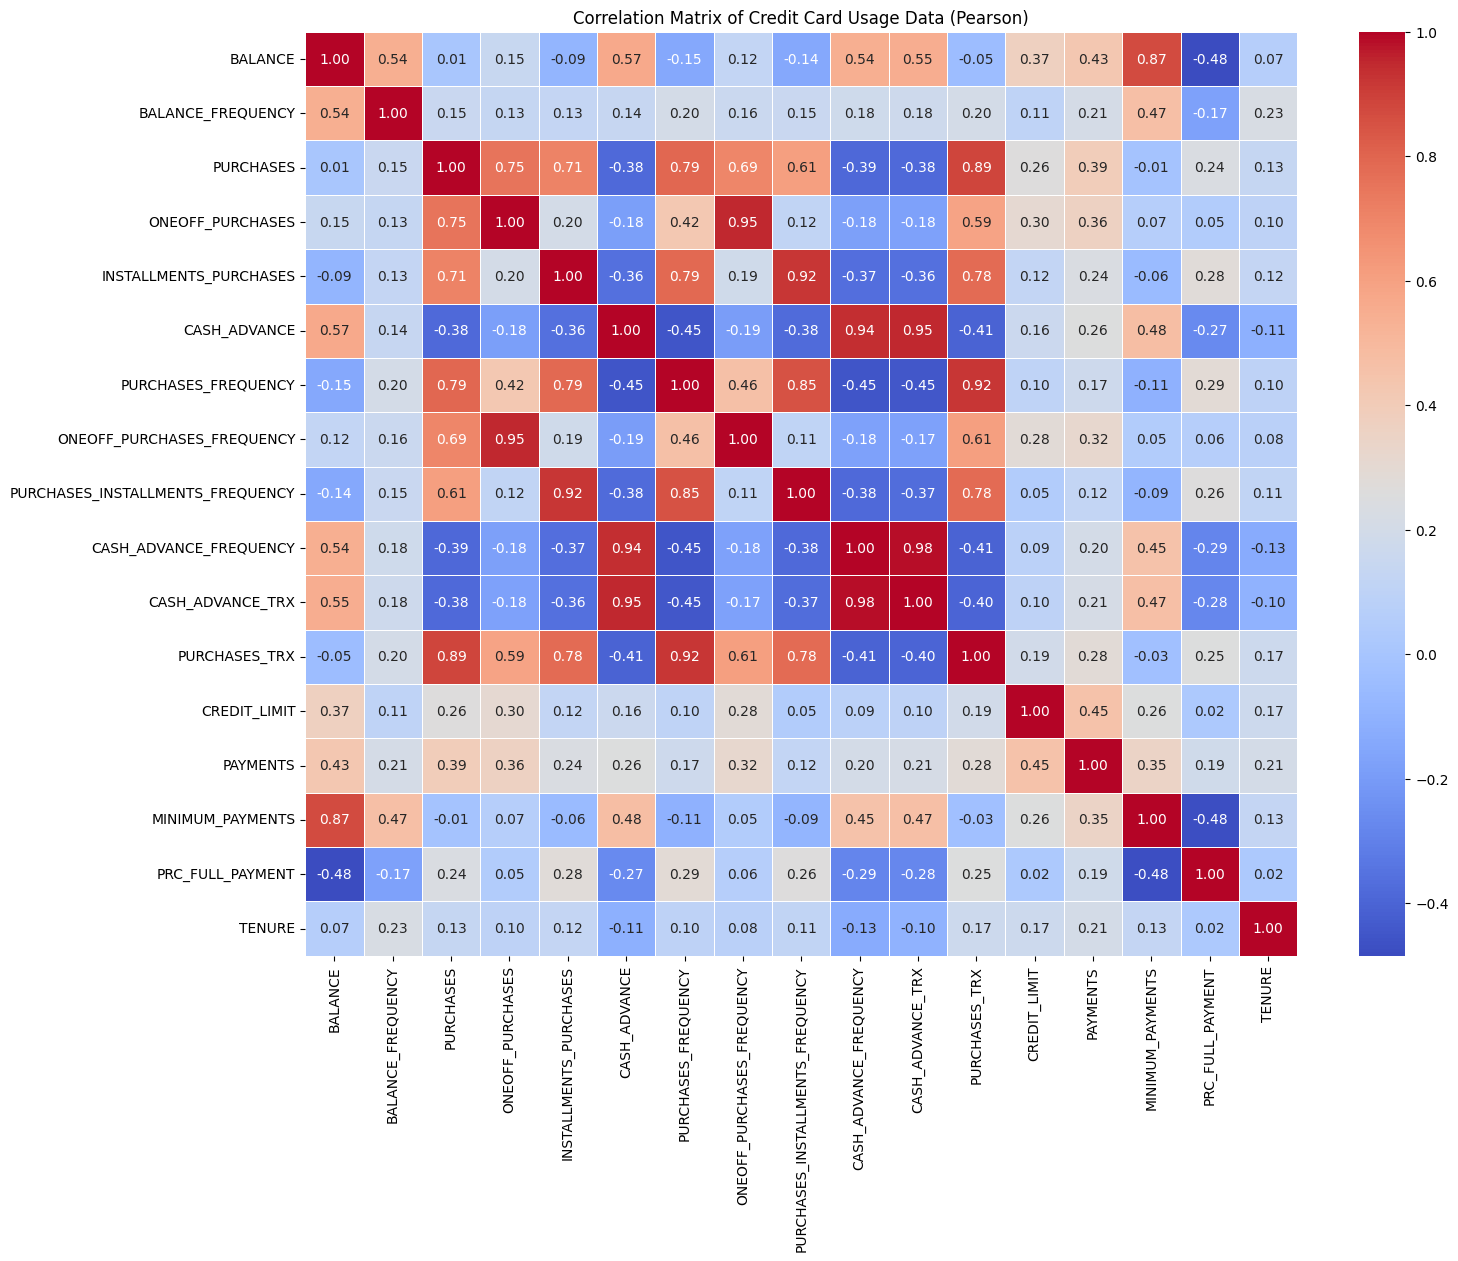

In [30]:
numerical_df = df.select_dtypes(include=np.number)

# Spearman correlation matrix
spearman_corr = numerical_df.corr(method='spearman')
print("\nSpearman Correlation Matrix (first 5 rows):")
#print(spearman_corr.head())
plt.figure(figsize=(16, 12))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Credit Card Usage Data (Pearson)')
plt.show()

In [36]:
# Calculate Credit Utilization
df['credit_utilization'] = df['BALANCE'] / df['CREDIT_LIMIT']
df['payment_ratio'] = df['PAYMENTS'] / df['MINIMUM_PAYMENTS']

# Fix purchase_frequncy: Set to 0 when PURCHASES == 0
df['purchase_frequncy'] = np.where(df['PURCHASES'] == 0, 0, df['CASH_ADVANCE'] / df['PURCHASES'])

# Fix average_transaction_value: Set to 0 when PURCHASES_TRX == 0
df['average_transaction_value'] = np.where(df['PURCHASES_TRX'] == 0, 0, df['PURCHASES'] / df['PURCHASES_TRX'])


# Calculate Purchase Mix Ratios
# Avoid division by zero by checking if PURCHASES is greater than 0
df['oneoff_purchase_ratio'] = df.apply(
    lambda row: row['ONEOFF_PURCHASES'] / row['PURCHASES'] if row['PURCHASES'] > 0 else 0,
    axis=1
)

df['installments_purchase_ratio'] = df.apply(
    lambda row: row['INSTALLMENTS_PURCHASES'] / row['PURCHASES'] if row['PURCHASES'] > 0 else 0,
    axis=1
)

# Display the new columns and the relevant original columns
display(df[['PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'oneoff_purchase_ratio', 'installments_purchase_ratio']].head())
display(df[['credit_utilization', 'payment_ratio', 'purchase_frequncy','average_transaction_value', 'oneoff_purchase_ratio', 'installments_purchase_ratio']].head())



,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,oneoff_purchase_ratio,installments_purchase_ratio
0,4.568506,0.000000,4.568506,0.0,1.0
1,0.000000,0.000000,0.000000,0.0,0.0
2,6.651791,6.651791,0.000000,1.0,0.0
3,7.313220,7.313220,0.000000,1.0,0.0
4,2.833213,2.833213,0.000000,1.0,0.0


,credit_utilization,payment_ratio,purchase_frequncy,average_transaction_value,oneoff_purchase_ratio,installments_purchase_ratio
0,0.540662,1.074203,0.000000,4.158434,0.0,1.0
1,0.911697,1.192189,0.000000,0.000000,0.0,0.0
2,0.876688,0.998706,0.000000,2.593342,1.0,0.0
3,0.831487,0.000000,0.729049,10.550747,1.0,0.0
4,0.945963,1.184692,0.000000,4.087463,1.0,0.0


# credit_utilization
- mesures how much the available credit a customer is using  higher the ration more fianancial stress

# payment_ratio
- how customers are paying back their spends  >1 is good sign as they are paying more than minimum and lenders look at this to assses repayment discipline

#  purchase_frequncy
- Ratio of cash advances to purchases.High ratio: Prefers cash advances over purchases (riskier behavior)

# average_transaction_value

- Average amount per purchase transaction.
- Higher values: Fewer, larger purchases

# oneoff_purchase_ratio

- installment payment to total payment and higer ration indicate prefer lumpsum payments it indicates financial planning habits and risk tolerance


#  installments_purchase_ratio

- Share of purchases made via installments.
- High ratio: Prefers to spread payments.Useful for marketing (targeting with EMI offers) and risk.

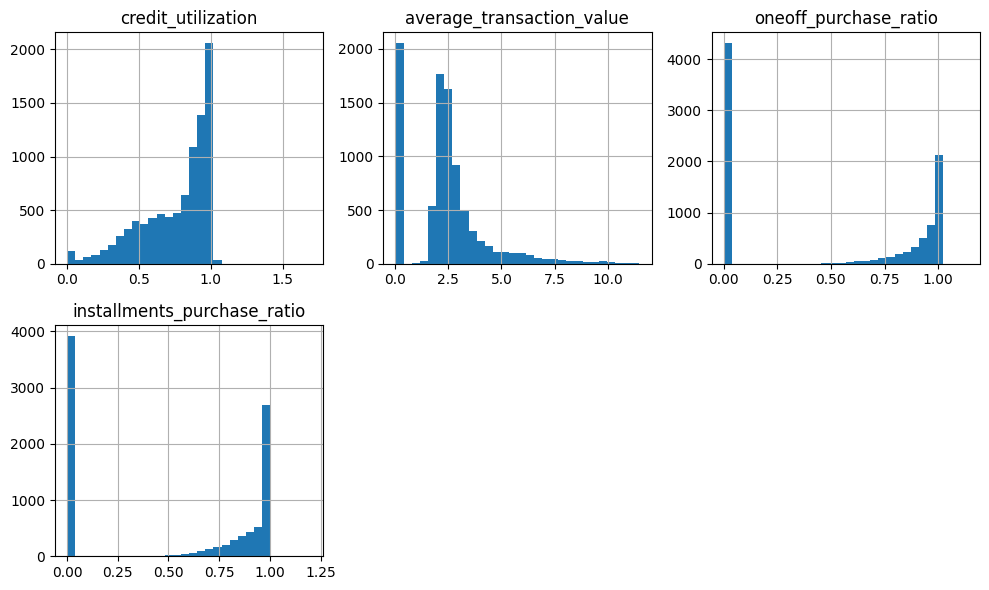

In [42]:
import matplotlib.pyplot as plt

params = [
    'credit_utilization',
    'average_transaction_value', 'oneoff_purchase_ratio', 'installments_purchase_ratio'
]

df[params].hist(bins=30, figsize=(10, 6), layout=(2, 3))
plt.tight_layout()
plt.show()


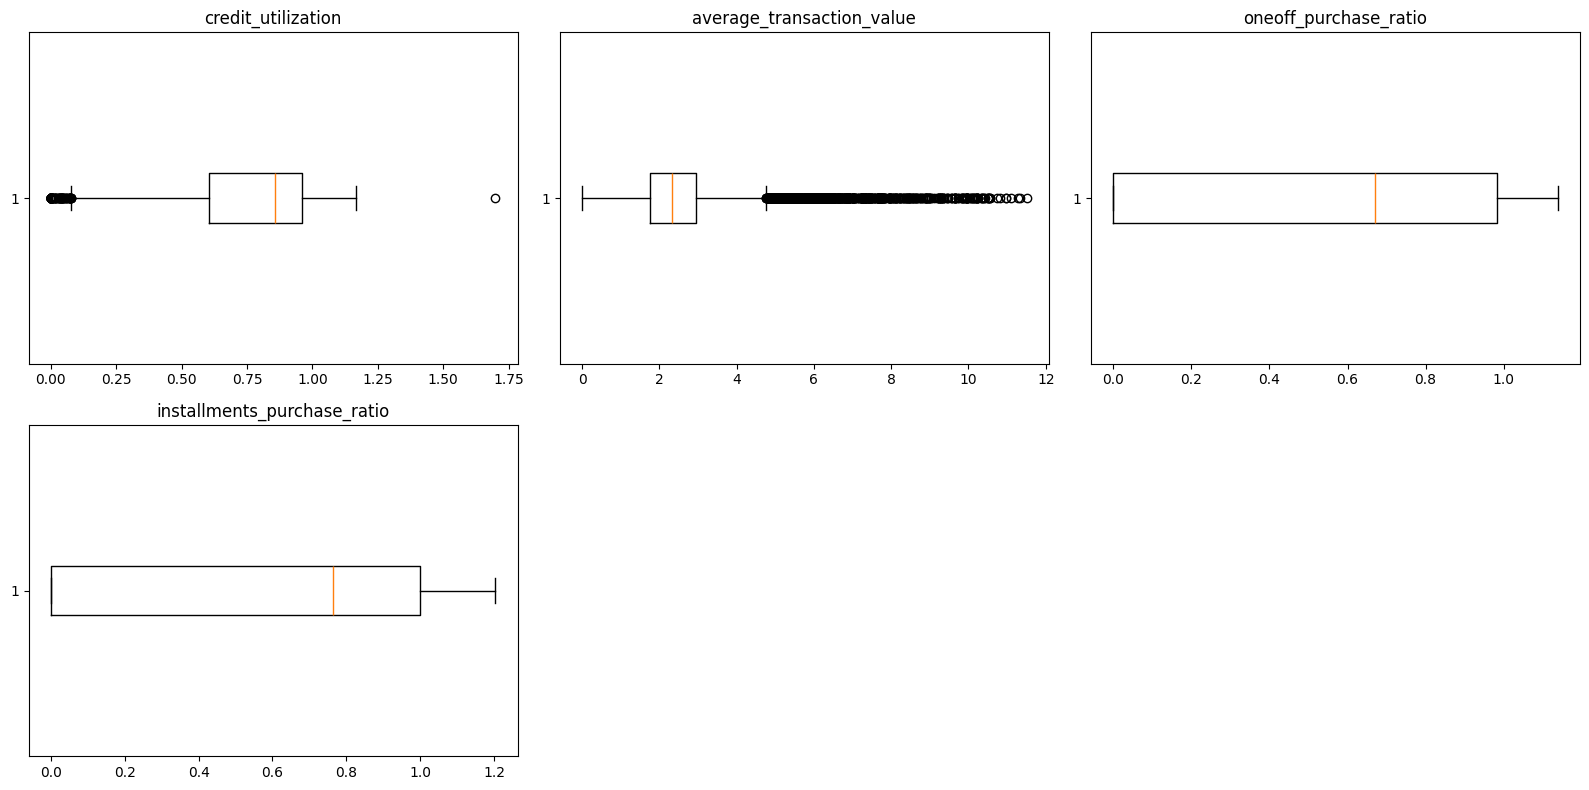

In [48]:
plt.figure(figsize=(16, 8))
for i, param in enumerate(params):
    plt.subplot(2, 3, i+1)
    plt.boxplot(df[param].dropna(), vert=False)
    plt.title(param)
plt.tight_layout()
plt.show()


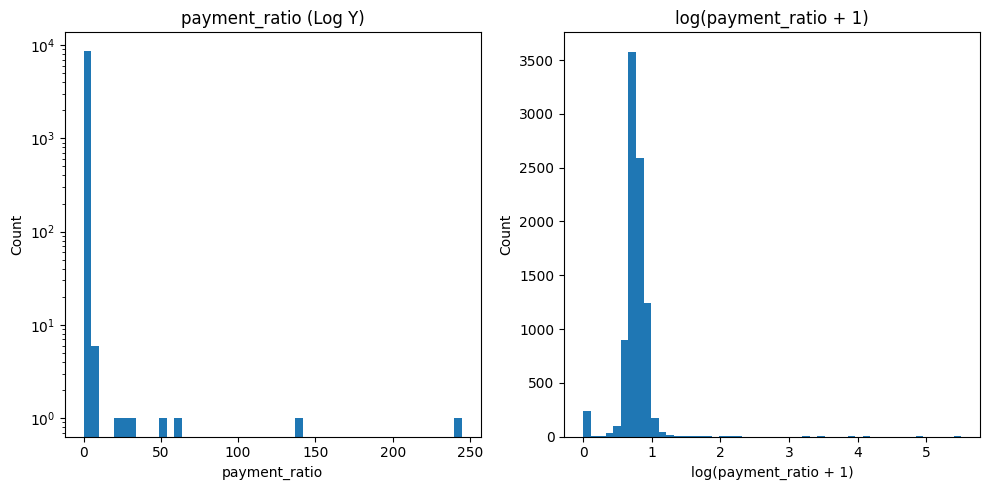

In [47]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# 1. payment_ratio
axs[0].hist(df['payment_ratio'].replace(0, np.nan).dropna(), bins=50, log=True)
axs[0].set_title('payment_ratio (Log Y)')
axs[0].set_xlabel('payment_ratio')
axs[0].set_ylabel('Count')

# Optionally, plot log of payment_ratio
axs[1].hist(np.log1p(df['payment_ratio']), bins=50)
axs[1].set_title('log(payment_ratio + 1)')
axs[1].set_xlabel('log(payment_ratio + 1)')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


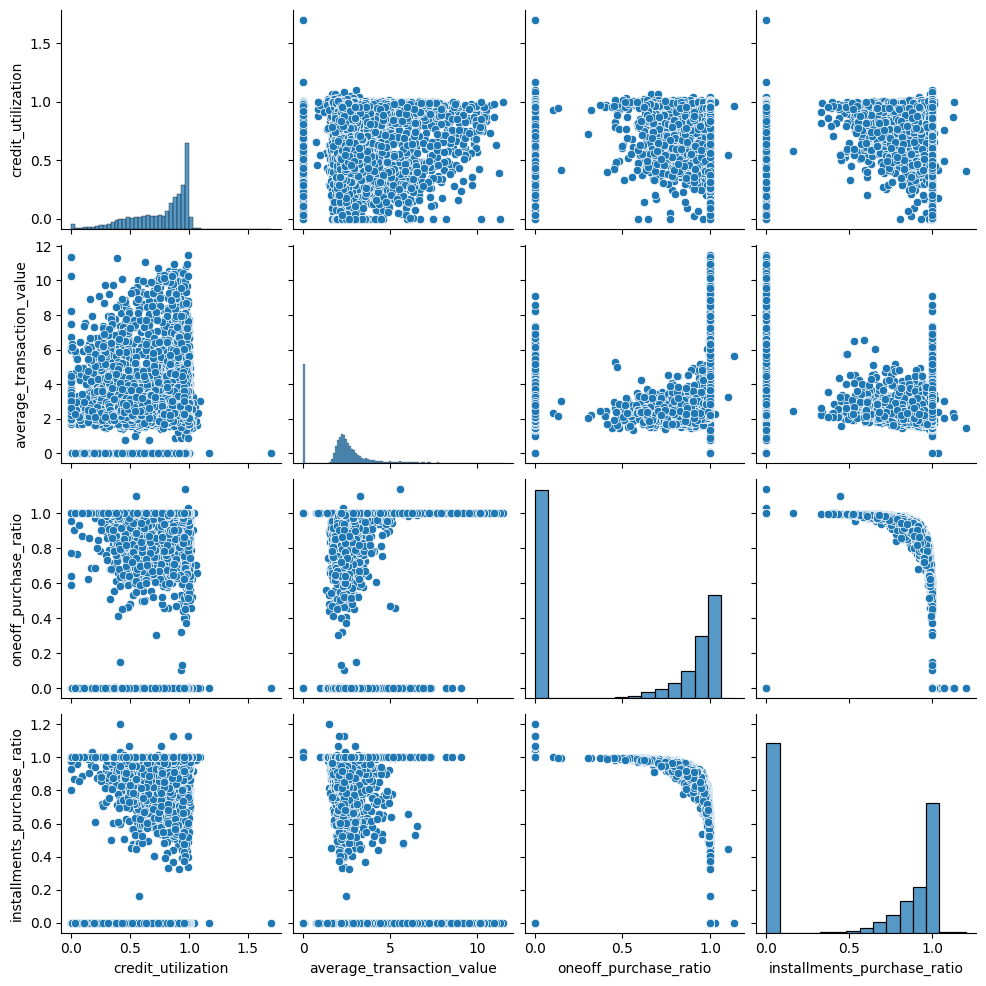

In [51]:
sns.pairplot(df[['credit_utilization', 'average_transaction_value', 'oneoff_purchase_ratio', 'installments_purchase_ratio']])


<Axes: ylabel='count'>

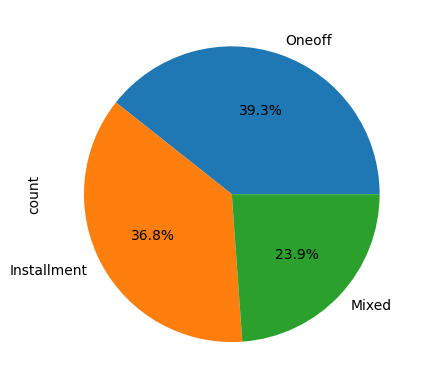

In [54]:
df['main_purchase_type'] = np.where(df['oneoff_purchase_ratio'] > 0.9, 'Oneoff',
                           np.where(df['installments_purchase_ratio'] > 0.9, 'Installment', 'Mixed'))
df['main_purchase_type'].value_counts().plot.pie(autopct='%1.1f%%')


In [56]:
def assign_segment(row):
    if row['credit_utilization'] > 0.8 and row['payment_ratio'] < 1:
        return 'High Util, Low Repay'
    elif row['oneoff_purchase_ratio'] > 0.9:
        return 'Oneoff Only'
    elif row['installments_purchase_ratio'] > 0.9:
        return 'Installments Only'
    elif row['average_transaction_value'] > df['average_transaction_value'].quantile(0.95):
        return 'Big Spender'
    else:
        return 'Typical'

df['customer_segment'] = df.apply(assign_segment, axis=1)
print(df['customer_segment'].value_counts())


customer_segment
Oneoff Only             2782
Installments Only       2699
High Util, Low Repay    2134
Typical                 1335
Name: count, dtype: int64


# credit_utilization
- most of the customers are utilizing their limit as we can see the concentration of values between 0.5 and 1.0

- yes there are customers who are utilizing their max limits but their repayments matters to check their potential addition to profits to bank

### purchase_frequncy and  installments_purchase_ratio helping parametrs to categorize

# payment_ratio
- larger spike is close to 0 meaning most of the customers make samll trasaction

- checking their repayment and encoraging the larger purchasers would truly help but these customers must be category where they are good with repayments

### oneoff_purchase_ratio and average_transaction_value helping parametrs to categorize

